# Imports

These imports are used for setting up ISST, making everything importable, etc.

In [1]:
import os
from pathlib import Path

import sys
ISST_DIR = str(Path(os.getcwd()).parent.parent.parent)
sys.path.append(ISST_DIR)

import numpy as np
import arviz as az
import pymc as pm

import ISST

# Cost and Schedule Impact Tables

We'll start by defining specific risk tables. Risk tables take five arguments:

`name`: The name of the risk table - this is the parameter that it tracks
`units`: The units of the parameter being tracked
`utility_breakpoints`: Separation points between levels of utility associated with the parameters
`utility`: The utilities in the region following the corresponding breakpoints
`utility_names`: Plain language descriptions of the utility levels

First up is cost, with breakpoints measured in Euros, with a maximum utility impact of -10 at more than 100M Euros of budget impact. Let's see what happens when we try to fit a utility function here:

In [2]:
Cost_Risk_Table = ISST.ImpactTable(name='Cost',
                                   units='euros',
                                   utility_breakpoints=[0.,1e5, 1e6, 5e6, 1e7, 5e7, 1e8],
                                   utilities=[0., -1., -2., -4., -6., -8., -10.],
                                   utility_names=['0 Euros',
                                                  '100k Euros',
                                                  '1M Euros',
                                                  '5M Euros',
                                                  '10M Euros',
                                                  '50M Euros',
                                                  '100M Euros'])

Cost_Risk_Table.plot_utilities()

AttributeError: module 'ISST' has no attribute 'ImpactTable'

The fitting tries its best, but the several orders of magnitude change in the breakpoints make it hard to fit the utility function. Let's adjust by making the breakpoints logarithmic. Let's recalculate what our breakpoints are:

In [4]:
print(np.log10(Cost_Risk_Table.utility_breakpoints))

[   -inf 5.      6.      6.69897 7.      7.69897 8.     ]


Note that while our original breakpoints started at 0., that leads to a logarithmic break-point of `-inf`, so we'll have to trim that off in redefining the `utility_breakpoints` attribute:

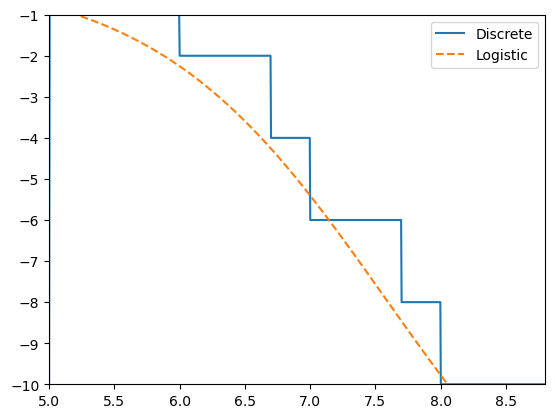

In [5]:
Log_Cost_Risk_Table = ISST.ImpactTable(name='LogCost',
                                       units='logEUR',
                                       utility_breakpoints=np.log10(Cost_Risk_Table.utility_breakpoints)[1:],
                                       utilities=Cost_Risk_Table.utilities[1:],
                                       utility_names=['100k Euros',
                                                      '1M Euros',
                                                      '5M Euros',
                                                      '10M Euros',
                                                      '50M Euros',
                                                      '100M Euros'])

Log_Cost_Risk_Table.plot_utilities()

We can retain the `utility_names` to help us read off what the levels mean in linear space. Note that since the units of the cost table are not logarithmic, we'll have to be careful to specify the units when calculating utilities with it. What happens when we pass a 5M Euro budget impact?

In [6]:
Log_Cost_Risk_Table.logistic_utility(5e6)

array(-15.79898015)

The utility function gives us ~-15.8 utility, even though 5M should be right in the middle of our utility breakpoints. We need to convert to logarithmic inputs in order to get the utility function to work:

In [7]:
Log_Cost_Risk_Table.logistic_utility(np.log10(5e6))

array(-4.25859744)

And here we see that instead of -15.8, we get an impact of -4.26, right where we expect to be. Next is schedule, with impact denominated in months of schedule delay, maximum utility impact of -10 at more than 120 months = 10 years of schedule delay. Note that we use a fractional utility breakpoint of -0.5 for the 3-month breakpoint.

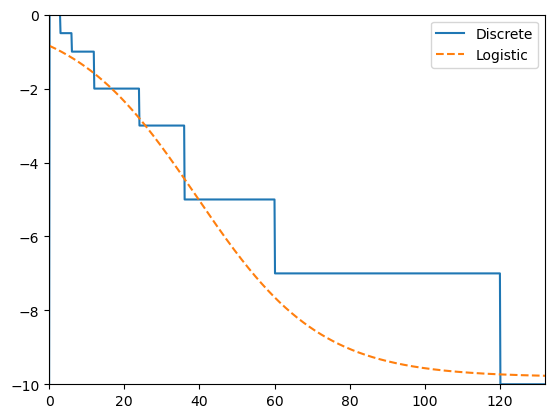

In [8]:
Schedule_Risk_Table = ISST.ImpactTable(name='Schedule',
                                       units='months',
                                       utility_breakpoints=[0., 3., 6., 12., 24., 36., 60., 120.],
                                       utilities=[0., -0.5, -1., -2., -3., -5., -7., -10.],
                                       utility_names=['0 months',
                                                      '3 months',
                                                      '6 months',
                                                      '12 months',
                                                      '24 months',
                                                      '36 months',
                                                      '60 months',
                                                      '120 months'])
Schedule_Risk_Table.plot_utilities()

This is a much more reasonable fit, but it points out that there's a large gap as we get closer to 120 months of schedule delay. Let's adjust and re-fit by adding a 90-month breakpoint with -9 utility:

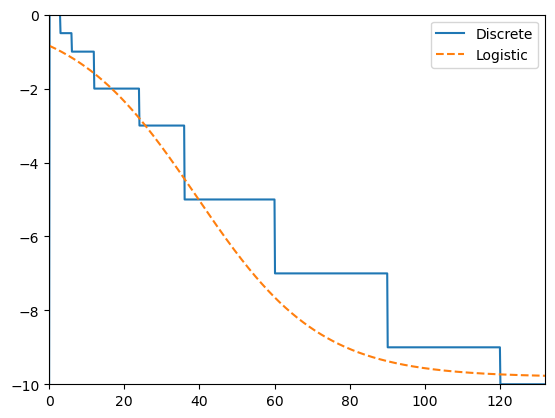

In [9]:
Schedule_Risk_Table.utility_breakpoints = [0., 3., 6., 12., 24., 36., 60., 90., 120.]
Schedule_Risk_Table.utilities = [0., -0.5, -1., -2., -3., -5., -7., -9., -10.]
Schedule_Risk_Table.fit_utilities()
Schedule_Risk_Table.plot_utilities()

# Technical Risk Tables

Technical Risk Tables are more particular, since they'll depend on your individual projects, but let's try and set up a few based on the RFP. First, lets consider the RFP's requirement that misison planning evaluate the site selection's effect on delta-V. We know that the effective delta-V benefit of a site is proportional to `cos(latitude)`, so we can build some of that knowledge in by making our utility levels vary similarly:

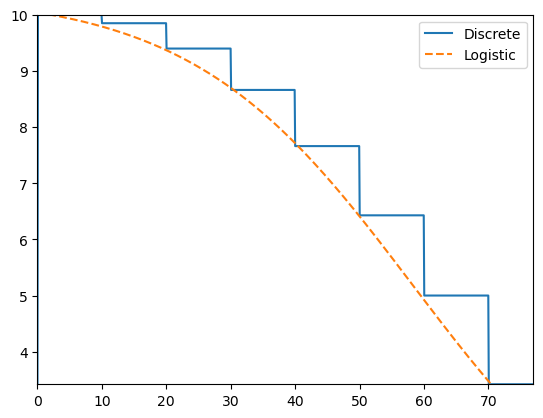

In [10]:
latitudes = [0., 10., 20., 30., 40., 50., 60., 70.]
lat_utilities = 10 * np.cos(np.deg2rad(latitudes))

Site_Latitude = ISST.ImpactTable(name='Site_DV',
                                 units = 'deg-latitude',
                                 utility_breakpoints=latitudes,
                                 utilities=lat_utilities,
                                 utility_names=['0 degrees',
                                                '10 degrees',
                                                '20 degrees',
                                                '30 degrees',
                                                '40 degrees',
                                                '50 degrees',
                                                '60 degrees',
                                                '70 degrees'])

Site_Latitude.plot_utilities()

Next, let's add a risk table for payload's requirement of 800 W sustained power. We decide that we want to be very tight around the minimum requirement so we specify our utilities like this: 

In [11]:
power_levels = [0., 800.]
power_utilities = [0., 10.]

try:
    Payload_Power = ISST.ImpactTable(name='Payload_Power',
                                     units = 'W',
                                     utility_breakpoints=power_levels,
                                     utilities=power_utilities,
                                     utility_names=['Below Spec',
                                                    'Meet Spec'])
except:
    print('Failed to build Payload_Power.')

Failed to build Payload_Power.


Uh oh. The logistic function has three parameters, so we need to specify at least three data points to fit it. Let's try:

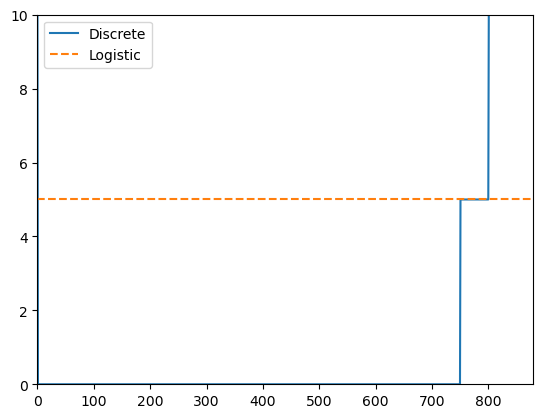

In [12]:
Payload_Power = ISST.ImpactTable(name='Payload_Power',
                                 units = 'W',
                                 utility_breakpoints=[0., 750., 800.],
                                 utilities=[0., 5., 10.],
                                 utility_names=['Below Spec',
                                                'Near Spec',
                                                'Meet Spec'])
Payload_Power.plot_utilities()

Still not quite getting there. We might be happy to just use the discrete utilities, but as an alternative, we can call the logistic function directly using custom parameters:

In [13]:
print(Payload_Power.utility(810., mode='logistic', L=10.,k=1000., x0=800.))

custom_utiliity = lambda x: 10 * np.exp(-((x-800.)**2)/3000)

print(Payload_Power.utility(860., mode='custom', u_func=custom_utiliity))

10.0
3.0119421191220215


Let's go ahead and set the risk table's internal properties to these custom values manually and then try plotting again:

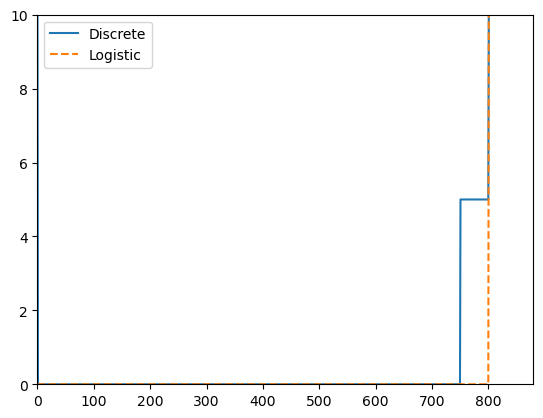

In [14]:
Payload_Power.L = 10
Payload_Power.k = 1000
Payload_Power.x0 = 800

Payload_Power.plot_utilities()

Now they're agreeing pretty well. Let's move on to Launch Vehicle and try and set up a table for our payload requirement. The RFP requires a minimum of 600 kg, and let's say we've talked to the payload team, and they think they really want us to get to 1000 kg, and would be totally satisfied if we got to 1500 kg, so we set up the Risk Table as:

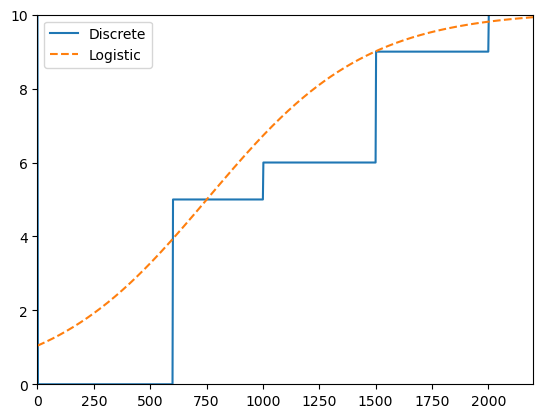

In [15]:
Payload = ISST.ImpactTable(name='Payload',
                           units='kg',
                           utility_breakpoints = [0., 600., 1000., 1500., 2000.],
                           utilities = [0., 5., 6., 9., 10.],
                           utility_names = ['Below Spec',
                                            'Meet Spec',
                                            'Payload OK',
                                            'Payload Happy',
                                            'Exceed Spec'])

Payload.plot_utilities()

Great, let's move on to identifying our Risks.

# Risks

Risks need just two parameters to create:

`name`: A plain language description of the risk
`baseline_likelihood`: The chance that this risk will occur

In [16]:
Strike_Risk = ISST.Risk(name='Workers Strike', baseline_likelihood = 0.05)

Inflation_Risk = ISST.Risk(name='High Inflation', baseline_likelihood = 0.10)

With the risks preliminarily defined, we can now define our Design System.

# Design System

We can define the design system by naming it, and directing it to the risks and risk tables we want it to consider, along with a PyMC model.

The DesignSystem has the following parameters:

`name`: Reference name for the system
`risks`: ISST Risk Modules that the system will account for
`schedule_risk_table`: ISST Risk Table for Schedule Impact
`cost_risk_table`: ISST Risk Table for Cost Impact
`technical_risk_tables`: LIST of ISST Risk Tables for Technical Impacts

In [17]:
Example_Design_System = ISST.DesignSystem(name='Example_Design_System',
                                          model_context=pm.Model(),
                                          risks=[Strike_Risk, Inflation_Risk],
                                          schedule_risk_table = Schedule_Risk_Table,
                                          cost_risk_table = Log_Cost_Risk_Table,
                                          technical_risk_tables = [Payload])                                          

With the system defined, we can now begin generating the system spec:

In [18]:
# Example_Design_System.generate_system_specification()

Once this function is run, ISST will create a set of CSV spreadsheet files that can be used to fully specify the risks for your design. When filling them out, remember that the units for the risk tables!

In [19]:
Example_Design_System.read_system_specification()

Let's check that the system specification is correct:

In [20]:
print(f'Risk Name: {Example_Design_System.risks[0].name}')
print(f'Minimum Schedule Impact: {Example_Design_System.risks[0].schedule_risk_minimum_value} months.')
print(f'Maximum Schedule Impact: {Example_Design_System.risks[0].schedule_risk_maximum_value} months.')
print(f'Most Likely Schedule Impact: {Example_Design_System.risks[0].schedule_risk_most_likely_value} months.')

Risk Name: Workers Strike
Minimum Schedule Impact: 6.0 months.
Maximum Schedule Impact: 24.0 months.
Most Likely Schedule Impact: 12.0 months.


# System Analysis

With the system specified, we can now analyze the entire system at once (this will take a while):

In [21]:
# results = Example_Design_System.analyze_system()
results = az.from_netcdf("Example Results.nc")

array([<Axes: title={'center': 'Total Cost Impact'}>,
       <Axes: title={'center': 'Total Schedule Impact'}>,
       <Axes: title={'center': 'Total Payload Impact'}>], dtype=object)

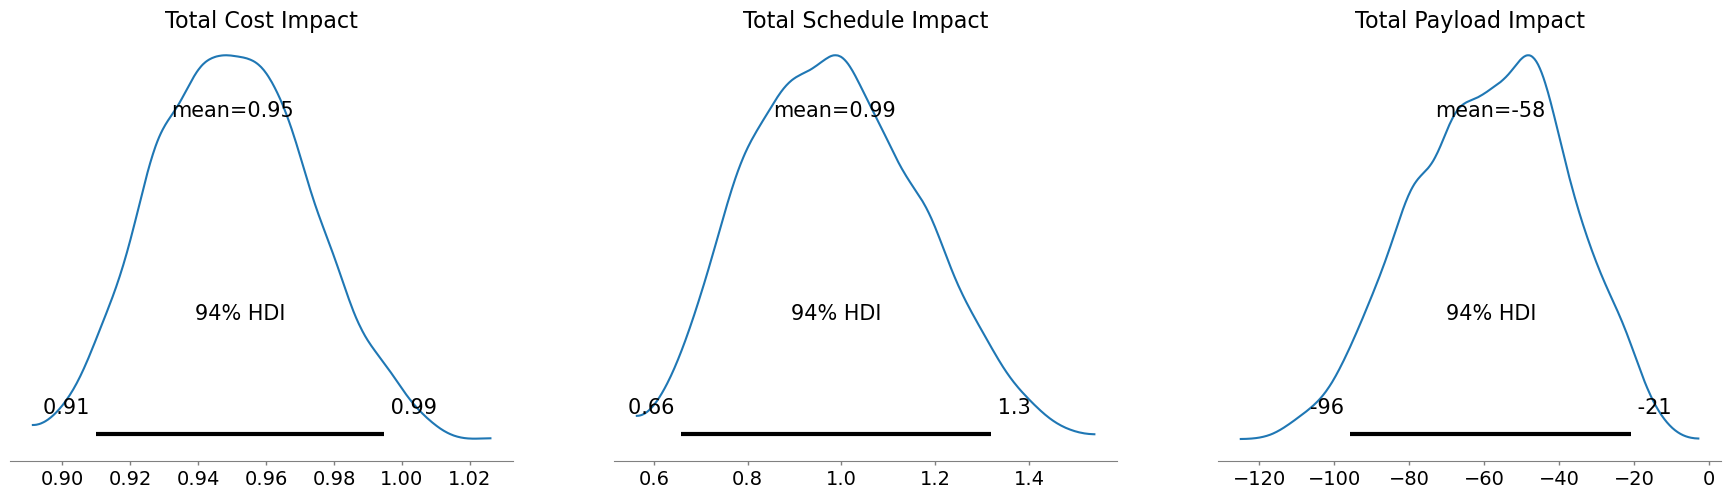

In [22]:
az.plot_posterior(results, var_names=['Total'], filter_vars='like')

In [23]:
az.summary(results,
           var_names=['Total'],
           filter_vars="like",
           round_to=2,
           kind='stats')

,mean,sd,hdi_3%,hdi_97%
Total Cost Impact,0.95,0.02,0.91,0.99
Total Schedule Impact,0.99,0.18,0.66,1.32
Total Payload Impact,-58.47,20.64,-95.72,-20.87


PosixPath('/Users/jordan/git/ISST/Notebooks/Example_Design_System/Example_Design_System Analysis Report')

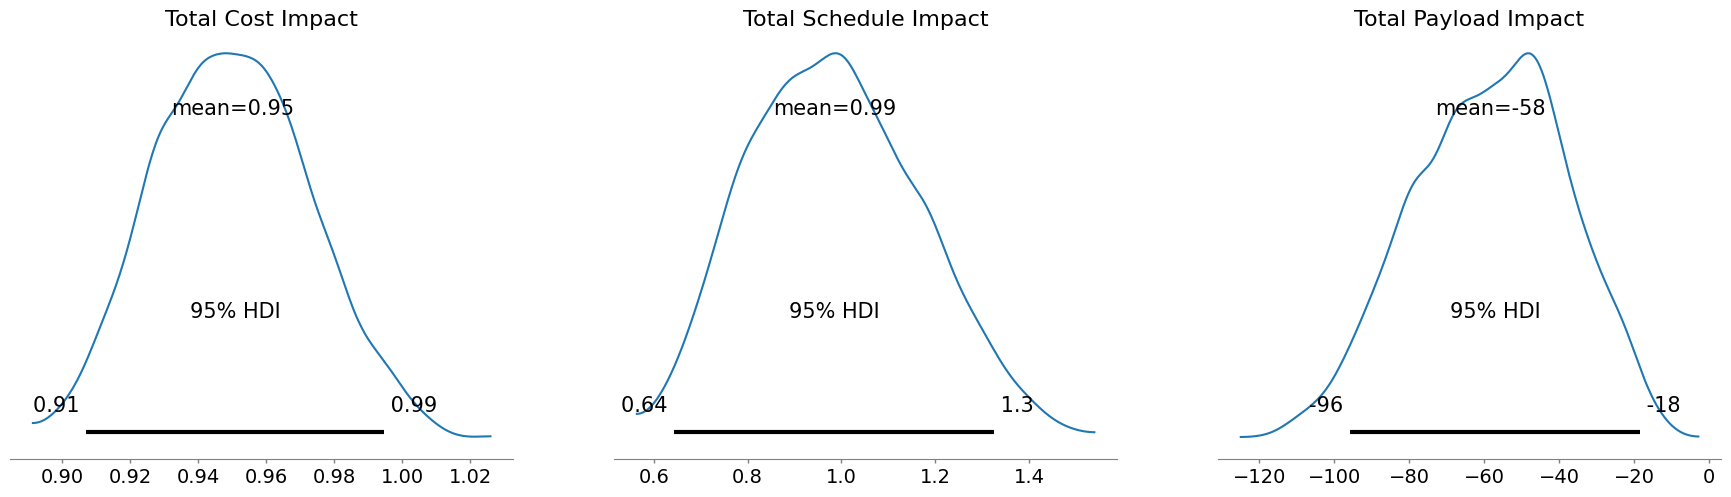

In [23]:
Example_Design_System.write_system_results(results)